## Region-specific behaviour: the lake case

In [1]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-notebook")
%config InlineBackend.figure_format='svg' # Setting figure format for this notebook
import numpy as np
import pygimli as pg
from pygimli.physics import ert

The data was measured across a shallow lake with the most electrodes being on the bottom of the approx. 2.5m deep lake. We used cables with 2m spaced takeouts.

In [2]:
data = ert.load("data/lake.ohm")
print(data)

Data: Sensors: 48 data: 658, nonzero entries: ['a', 'b', 'err', 'i', 'm', 'n', 'r', 'u', 'valid']


The data set contains current and voltage.

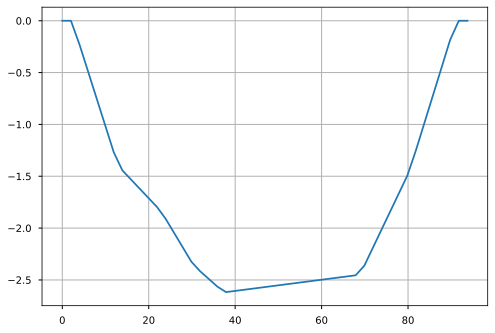

In [3]:
plt.plot(pg.x(data), pg.z(data), "x-")
plt.grid();

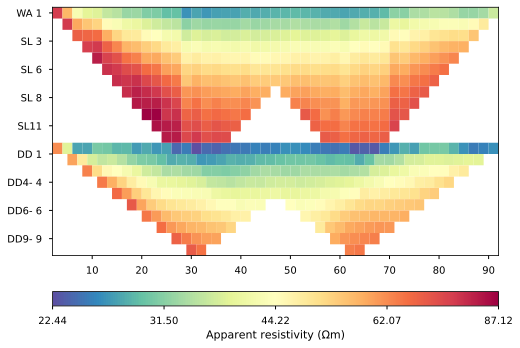

In [4]:
data["k"] = ert.geometricFactors(data)
data["rhoa"] = data["u"] / data["i"] * data["k"]
ert.show(data);

We combined Wenner-Schlumberger (top) and Wenner-beta (bottom) data. The lowest resistivities correspond with the water resistivity of 22.5 $\Omega$m. 

The data are measured standard devitations and should not be used for inversion. Instead, we estimate new errors.

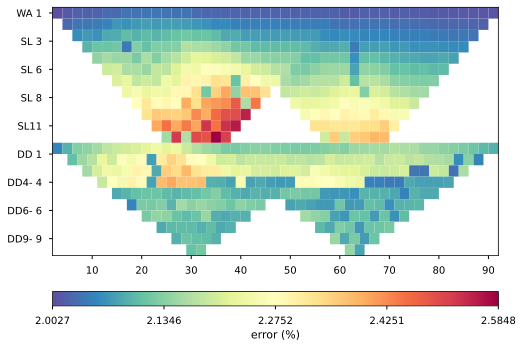

In [5]:
data["err"] = ert.estimateError(data, relativeError=0.02, absoluteUError=100e-6)
pg.show(data, data["err"]*100, label="error (%)");

0 -4.0 0.0
1 -4.0 -20.0
2 97.7452 -20.0
3 97.7452 0.0
4 -13.37452 0.0
5 -13.37452 -29.37452
6 107.11972 0.0
7 107.11972 -29.37452
8 0.0 0.0
9 1.0 0.0
10 2.0 0.0
11 2.993365 -0.11499999999999999


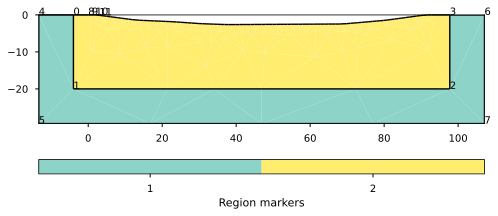

In [6]:
# We create a piece-wise linear complex (PLC) as for a case with topography
import pygimli.meshtools as mt
plc = mt.createParaMeshPLC(data, paraDepth=20, boundary=0.1)
ax, _ = pg.show(plc);
for i, n in enumerate(plc.nodes()[:12]):
    ax.text(n.x(), n.y(), str(i))
    print(i, n.x(), n.y())

In [7]:
# So node number 10 is the left one at the shore
for i in range(95, plc.nodeCount()):
    print(i, plc.node(i).x(), plc.node(i).y())

95 86.7804 -0.5833335
96 87.7715 -0.45
97 88.76255 -0.3166665
98 89.75359999999999 -0.183333
99 90.7494 -0.0916665
100 91.7452 0.0
101 92.7452 0.0
102 93.7452 0.0


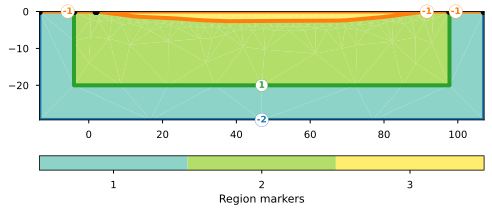

In [8]:
# and 100 the first on the other side. We connect nodes 10 and 100 by an edge
plc.createEdge(plc.node(10), plc.node(100), marker=-1)
plc.addRegionMarker([50, -0.1], marker=3)
pg.show(plc, markers=True);

Region 3 represents the water body and should be treated differently. We expect it to be rather homogeneous, maybe with a slight layering.

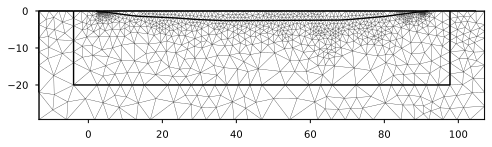

In [9]:
mesh = mt.createMesh(plc, quality=34.4)
pg.show(mesh, showMesh=True);

In [10]:
mgr = ert.ERTManager(data)
mgr.invert(mesh=mesh)

24/04/22 - 21:52:15 - pyGIMLi - INFO - Found 3 regions.
24/04/22 - 21:52:15 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/04/22 - 21:52:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/22 - 21:52:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/22 - 21:52:15 - pyGIMLi - INFO - Use median(data values)=47.19631937576008
24/04/22 - 21:52:15 - pyGIMLi - INFO - Created startmodel from forward operator: 1838 [47.19631937576008,...,47.19631937576008]


1838 [92.2907472745175,...,92.61314017145098]

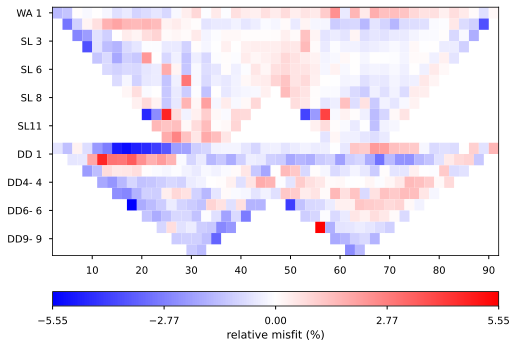

In [11]:
mgr.showMisfit();

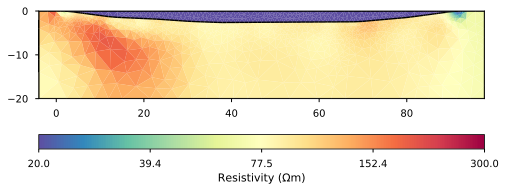

In [12]:
kw = dict(cMin=20, cMax=300, logScale=True, cMap="Spectral_r")
mgr.showResult(**kw);

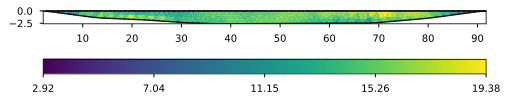

In [13]:
# Let us look in detail at the water cells
water = mesh.createSubMesh(mesh.cells(mesh.cellMarkers() == 3))
resWater = mgr.model[len(mgr.model)-water.cellCount():]
pg.show(water, resWater);

Apparently, all values are below the expected 22.5$\Omega$m and some are implausibly low. Therefore we should try to limit them.

24/04/22 - 21:52:40 - pyGIMLi - INFO - Use median(data values)=47.19631937576008
24/04/22 - 21:52:40 - pyGIMLi - INFO - Created startmodel from forward operator: 1838 [47.19631937576008,...,47.19631937576008]


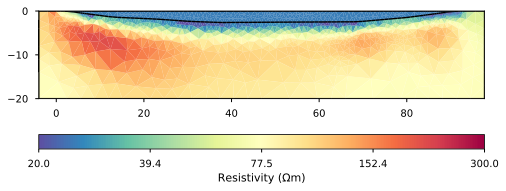

In [14]:
mgr.inv.setRegularization(3, limits=[20, 25], trans="log")
mgr.invert()
mgr.showResult(**kw);

As a result of the log-log transform, we have a homogeneous body but below the lake bottom values below 20, maybe due to clay content or maybe as compensation of limiting the water resistivity too strong. We could 

24/04/22 - 21:53:01 - pyGIMLi - INFO - Use median(data values)=47.19631937576008
24/04/22 - 21:53:01 - pyGIMLi - INFO - Created startmodel from forward operator: 1838 [47.19631937576008,...,47.19631937576008]


(<matplotlib.axes._subplots.AxesSubplot at 0x1f5fe436550>,
 <matplotlib.colorbar.Colorbar at 0x1f5fb28bdc0>)

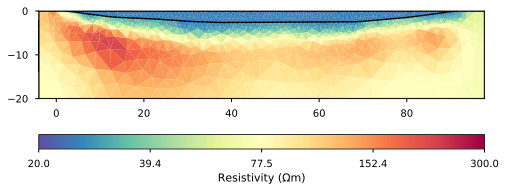

In [15]:
mgr.inv.setRegularization(2, limits=[20, 2000], trans="log")
mgr.invert()
mgr.showResult(**kw)

Another option is to treat the water body as a homogeneous body with only one unknown in the inversion.

24/04/22 - 21:53:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/22 - 21:53:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/22 - 21:53:28 - pyGIMLi - INFO - Use median(data values)=47.19631937576008
24/04/22 - 21:53:28 - pyGIMLi - INFO - Created startmodel from forward operator: 1406 [47.19631937576008,...,47.19631937576008]


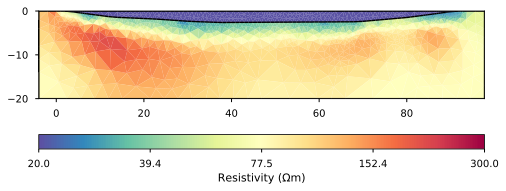

In [16]:
mgr.inv.setRegularization(3, single=True)
mgr.invert()
mgr.showResult(**kw);

In [26]:
print(len(mgr.model), mgr.inv.model)
min(mgr.model)
# water = mesh.createSubMesh(mesh.cells(mesh.cellMarkers() == 3))
# resWater = mgr.model[len(mgr.model)-water.cellCount():]
# pg.show(water, resWater);

1405 1405 [53.721433277715064,...,114.04832519939795]


26.23332669510564

24/04/22 - 22:21:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/22 - 22:21:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/22 - 22:21:11 - pyGIMLi - INFO - Use median(data values)=47.19631937576008
24/04/22 - 22:21:11 - pyGIMLi - INFO - Created startmodel from forward operator: 1405 [47.19631937576008,...,47.19631937576008]


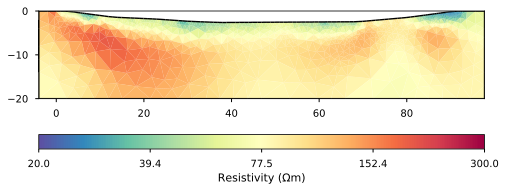

In [19]:
mgr.inv.setRegularization(3, fix=22.5)
mgr.invert()
mgr.showResult(**kw);

24/04/22 - 22:25:01 - pyGIMLi - INFO - Use median(data values)=47.19631937576008
24/04/22 - 22:25:01 - pyGIMLi - INFO - Created startmodel from forward operator: 1405 [47.19631937576008,...,47.19631937576008]
24/04/22 - 22:25:14 - pyGIMLi - INFO - Createing GeostatisticConstraintsMatrix for region 2 with: I=[30, 2], dip=0, strike=0
24/04/22 - 22:25:15 - pyGIMLi - INFO - (C) Time for eigenvalue decomposition: 0.6s
24/04/22 - 22:25:15 - pyGIMLi - INFO - Cache stored: C:\Guenther.T\Anwendungsdaten\pygimli\Cache\16935799546699455766


(<matplotlib.axes._subplots.AxesSubplot at 0x1f5a31ab400>,
 <matplotlib.colorbar.Colorbar at 0x1f5a2c38370>)

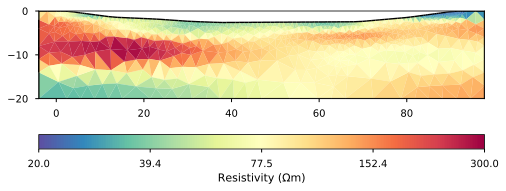

In [27]:
mgr.inv.setRegularization(2, correlationLengths=[30, 2])
mgr.invert()
mgr.showResult(**kw)